# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

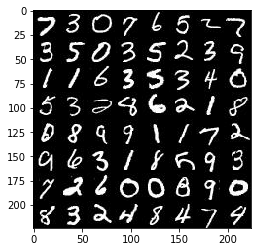

In [2]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

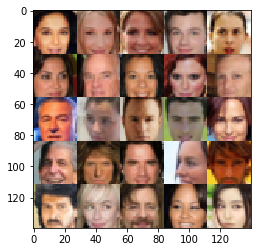

In [3]:
show_n_images = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data, learning rate)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Real Input Images with rank 4
    images = tf.placeholder(tf.float32, [None,image_width, image_height, image_channels], name='images')
    
    # Z input
    z_data = tf.placeholder(tf.float32, [None,z_dim], name='z_dim')
    
    #learning rate 
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return (images, z_data, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# Create Conv2d layer
def conv2d(inputs,filters):
    return tf.layers.conv2d( inputs,
                             filters,
                             6,
                             strides =2,
                             padding='same',
                             kernel_initializer= tf.contrib.layers.xavier_initializer_conv2d())                          

# leaky RELUs
def leaky_relu(val):
    return tf.maximum(val, 0.25*val)


# Discriminator
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):

        # First Layer
        first = conv2d(images , 64)
        first = leaky_relu(first)
        
        # Second Layer
        second = conv2d(first, 128)
        second = tf.layers.batch_normalization(second,training=True)
        second = leaky_relu(second)
        
        # Third Layer
        third = conv2d(second , 256)
        third = tf.layers.batch_normalization(third,training=True)
        third = leaky_relu(third)
        third = tf.reshape(third,(-1, 4*4*256))
        
        # Tensor Logits 
        logits = tf.layers.dense(third, 1)
        
        return (tf.sigmoid(logits), logits)         
           
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def conv2d_transpose(inputs, filters, xavier = tf.contrib.layers.xavier_initializer_conv2d()):
    return tf.layers.conv2d_transpose(inputs,
                                       filters,
                                       6, 
                                       strides=1, 
                                       padding='valid',
                                       kernel_initializer= xavier)

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    with tf.variable_scope('generator', reuse= reuse):
        
        # First Layer
        first = tf.layers.dense(z, 4*4*512)
        first = tf.reshape(first,(-1,4,4,512))
        first = tf.layers.batch_normalization(first, training=is_train)
        first = leaky_relu(first)
        print("first-shape ", first.shape)
        
        # Second Layer 
        second = conv2d_transpose(first,256)
        second = tf.layers.batch_normalization(second,training=is_train)
        second = leaky_relu(second)
        print("second-shape ", second.shape)
        
        # Third Layer
        third = conv2d_transpose(second,128)
        third = tf.layers.batch_normalization(third, training=is_train)
        third = leaky_relu(third)
        print("third-shape", third.shape)
        
        # Logits
        # revise this part 
        logits = tf.layers.conv2d_transpose(third, out_channel_dim, 5, strides= 2, padding = 'same')
        print("logits-shape", logits.shape)
        
        return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 5)
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # Get Generator 
    g_output = generator(input_z, out_channel_dim)
    
    # Get Discriminator tuple, real data-set 
    d_output, d_logits = discriminator(input_real)
    
    # Get Discriminator tuple, generated data-set
    f_output,f_logits = discriminator(g_output,reuse= True)
    
    
    ## Real loss
    real_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits, labels= tf.ones_like(d_output))
    real_loss = tf.reduce_mean(real_loss)
         
    ## Fake Loss    
    fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits= f_logits, labels = tf.zeros_like(f_output))
    fake_loss =  tf.reduce_mean(fake_loss)
    
    # Discriminator  Loss 
    discriminator_loss = real_loss + fake_loss
        
    # Generator Loss 
    generator_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits= f_logits, labels =tf.ones_like(f_output))
    generator_loss = tf.reduce_mean(generator_loss)
    
    return discriminator_loss,  generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 4)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get Trainable, Discriminator and Generator variables 
    t_vars = tf.trainable_variables()
    d_vars = [value for value in t_vars if value.name.startswith('discriminator')]
    g_vars = [value for value in t_vars if value.name.startswith('generator')]
    
    # Optimizing
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        
        d_opt = tf.train.AdamOptimizer(learning_rate,
                                      beta1 = beta1).minimize(d_loss, var_list = d_vars)
        
        g_opt = tf.train.AdamOptimizer(learning_rate,
                                      beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
        return (d_opt, g_opt) 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # data_shape
    size = data_shape[0]
    image_width = data_shape[1]
        
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    # (tensor of real input images, tensor of z data, learning rate)
    images, zdata, learn_rate = model_inputs(image_width, 
                                                image_height,
                                                image_channels,
                                                z_dim)
    
    
    # (discriminator loss, generator loss)
    d_loss, g_loss = model_loss(images, 
                               zdata,
                               image_channels)
    
    # (discriminator opt, generator opt)
    d_opt, g_opt = model_opt(d_loss, 
                              g_loss,
                              learning_rate,
                              beta1)
    
    n = 0
    n_print = 10
    n_show  = 100 
    
    print("Starting Training .. ")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                n += 1
                
                # Generate Randomness between -1 and 1 
                randomness = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                
                # Discriminator Optimization
                _ = sess.run(d_opt, feed_dict={images:batch_images, 
                                               zdata : randomness,
                                               learn_rate : learning_rate })
                
                # Generator Optimization 
                _ = sess.run(g_opt, feed_dict={zdata : randomness,
                                               images:batch_images,
                                               learn_rate : learning_rate})
                
                # Print Losses i n steps
                if n % n_print == 0:
                    d_training_loss = d_loss.eval({zdata : randomness ,
                                                  images : batch_images})
                    g_training_loss = g_loss.eval({zdata : randomness,
                                                  images : batch_images})
                    
                    print("Epoch {}/{} Batch Step {} ....".format(epoch_i, epoch_count, n),
                          "Discriminator Loss: {:.4f}....".format(d_training_loss),
                          "Generator Loss: {:.4f}...".format(g_training_loss))
                    
                # Show Images in n steps
                if n % n_show == 0:
                    show_generator_output(sess, 20, zdata, image_channels, data_image_mode )
                
    print(" Finished Training, Yay ! ")         
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 1)
Starting Training .. 
Epoch 0/2 Batch Step 10 .... Discriminator Loss: 0.5597.... Generator Loss: 9.6537...
Epoch 0/2 Batch Step 20 .... Discriminator Loss: 0.0040.... Generator Loss: 9.2764...
Epoch 0/2 Batch Step 30 .... Discriminator Loss: 0.1626.... Generator Loss: 6.8612...
Epoch 0/2 Batch Step 40 .... Discriminator Loss: 0.4269.... Generator Loss: 3.0701...
Epoch 0/2 Batch Step 50 .... Discriminator Loss: 2.3903.... Generator Loss: 10.4306...
Epoch 0/2 Batch Step 60 .... Discriminator Loss: 0.1566.... Generator Loss: 3.5117...
Epoch 0/2 Batch Step 70 .... Discriminator Loss: 3.7528.... Generator Loss: 0.1516...
Epoch 0/2 Batch Step 80 .... Discriminator Loss: 0.1363.... Generator Loss: 3.4722...
Epoch 0/2 Batch Step 90 .... Discriminator Loss: 0.2130.... Generator Loss: 3.0813...
Epoch 0/2 Batch Step 100 .... Discriminator Loss: 0.1131.... Generator Loss: 11.3674...
f

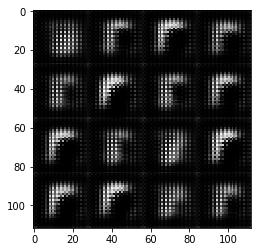

Epoch 0/2 Batch Step 110 .... Discriminator Loss: 0.7532.... Generator Loss: 1.0051...
Epoch 0/2 Batch Step 120 .... Discriminator Loss: 0.4901.... Generator Loss: 2.1092...
Epoch 0/2 Batch Step 130 .... Discriminator Loss: 1.9967.... Generator Loss: 0.3710...
Epoch 0/2 Batch Step 140 .... Discriminator Loss: 1.9328.... Generator Loss: 0.4956...
Epoch 0/2 Batch Step 150 .... Discriminator Loss: 1.2074.... Generator Loss: 5.9467...
Epoch 0/2 Batch Step 160 .... Discriminator Loss: 2.5206.... Generator Loss: 0.1627...
Epoch 0/2 Batch Step 170 .... Discriminator Loss: 0.2540.... Generator Loss: 2.0932...
Epoch 0/2 Batch Step 180 .... Discriminator Loss: 1.1144.... Generator Loss: 0.6230...
Epoch 0/2 Batch Step 190 .... Discriminator Loss: 0.6388.... Generator Loss: 1.5990...
Epoch 0/2 Batch Step 200 .... Discriminator Loss: 1.2942.... Generator Loss: 0.4429...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 1)


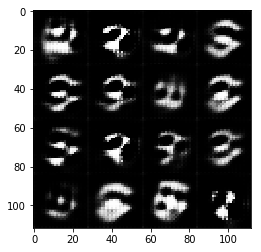

Epoch 0/2 Batch Step 210 .... Discriminator Loss: 0.5566.... Generator Loss: 2.0342...
Epoch 0/2 Batch Step 220 .... Discriminator Loss: 0.5344.... Generator Loss: 1.3006...
Epoch 0/2 Batch Step 230 .... Discriminator Loss: 0.6089.... Generator Loss: 2.8588...
Epoch 0/2 Batch Step 240 .... Discriminator Loss: 0.6260.... Generator Loss: 2.1624...
Epoch 0/2 Batch Step 250 .... Discriminator Loss: 0.8485.... Generator Loss: 5.1715...
Epoch 0/2 Batch Step 260 .... Discriminator Loss: 0.4765.... Generator Loss: 2.0189...
Epoch 0/2 Batch Step 270 .... Discriminator Loss: 0.4231.... Generator Loss: 2.3457...
Epoch 0/2 Batch Step 280 .... Discriminator Loss: 0.4478.... Generator Loss: 1.9634...
Epoch 0/2 Batch Step 290 .... Discriminator Loss: 0.4315.... Generator Loss: 1.4213...
Epoch 0/2 Batch Step 300 .... Discriminator Loss: 1.1277.... Generator Loss: 2.9627...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 1)


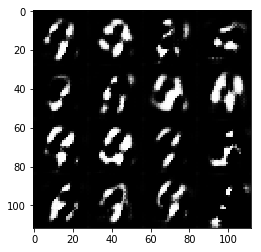

Epoch 0/2 Batch Step 310 .... Discriminator Loss: 0.7928.... Generator Loss: 1.3372...
Epoch 0/2 Batch Step 320 .... Discriminator Loss: 0.8822.... Generator Loss: 0.8167...
Epoch 0/2 Batch Step 330 .... Discriminator Loss: 0.6361.... Generator Loss: 1.4579...
Epoch 0/2 Batch Step 340 .... Discriminator Loss: 0.6390.... Generator Loss: 2.2433...
Epoch 0/2 Batch Step 350 .... Discriminator Loss: 1.0494.... Generator Loss: 3.5294...
Epoch 0/2 Batch Step 360 .... Discriminator Loss: 0.6642.... Generator Loss: 1.5060...
Epoch 0/2 Batch Step 370 .... Discriminator Loss: 0.6026.... Generator Loss: 1.7451...
Epoch 0/2 Batch Step 380 .... Discriminator Loss: 0.4421.... Generator Loss: 2.6447...
Epoch 0/2 Batch Step 390 .... Discriminator Loss: 0.9703.... Generator Loss: 4.0316...
Epoch 0/2 Batch Step 400 .... Discriminator Loss: 1.3344.... Generator Loss: 0.5326...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 1)


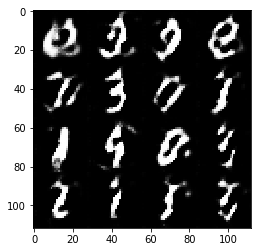

Epoch 0/2 Batch Step 410 .... Discriminator Loss: 0.3707.... Generator Loss: 1.7776...
Epoch 0/2 Batch Step 420 .... Discriminator Loss: 0.8810.... Generator Loss: 3.4704...
Epoch 0/2 Batch Step 430 .... Discriminator Loss: 0.8524.... Generator Loss: 0.9459...
Epoch 0/2 Batch Step 440 .... Discriminator Loss: 1.5816.... Generator Loss: 4.8866...
Epoch 0/2 Batch Step 450 .... Discriminator Loss: 1.5872.... Generator Loss: 4.7104...
Epoch 0/2 Batch Step 460 .... Discriminator Loss: 0.7082.... Generator Loss: 2.1508...
Epoch 0/2 Batch Step 470 .... Discriminator Loss: 0.5245.... Generator Loss: 2.6526...
Epoch 0/2 Batch Step 480 .... Discriminator Loss: 0.6536.... Generator Loss: 1.5542...
Epoch 0/2 Batch Step 490 .... Discriminator Loss: 0.8948.... Generator Loss: 3.1142...
Epoch 0/2 Batch Step 500 .... Discriminator Loss: 1.2704.... Generator Loss: 0.4818...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 1)


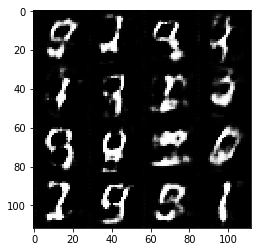

Epoch 0/2 Batch Step 510 .... Discriminator Loss: 1.5575.... Generator Loss: 0.4469...
Epoch 0/2 Batch Step 520 .... Discriminator Loss: 0.6749.... Generator Loss: 1.6533...
Epoch 0/2 Batch Step 530 .... Discriminator Loss: 0.7839.... Generator Loss: 1.3332...
Epoch 0/2 Batch Step 540 .... Discriminator Loss: 1.0664.... Generator Loss: 0.6609...
Epoch 0/2 Batch Step 550 .... Discriminator Loss: 1.0316.... Generator Loss: 0.6058...
Epoch 0/2 Batch Step 560 .... Discriminator Loss: 1.6327.... Generator Loss: 0.4026...
Epoch 0/2 Batch Step 570 .... Discriminator Loss: 1.6624.... Generator Loss: 0.3084...
Epoch 0/2 Batch Step 580 .... Discriminator Loss: 1.0296.... Generator Loss: 1.5937...
Epoch 0/2 Batch Step 590 .... Discriminator Loss: 1.1452.... Generator Loss: 0.7317...
Epoch 0/2 Batch Step 600 .... Discriminator Loss: 1.0836.... Generator Loss: 0.6412...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 1)


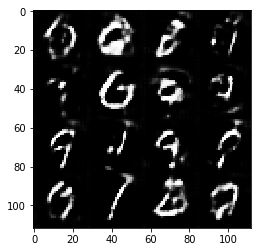

Epoch 0/2 Batch Step 610 .... Discriminator Loss: 0.7479.... Generator Loss: 1.8435...
Epoch 0/2 Batch Step 620 .... Discriminator Loss: 0.7192.... Generator Loss: 1.3207...
Epoch 0/2 Batch Step 630 .... Discriminator Loss: 0.8809.... Generator Loss: 1.3265...
Epoch 0/2 Batch Step 640 .... Discriminator Loss: 1.0208.... Generator Loss: 2.5189...
Epoch 0/2 Batch Step 650 .... Discriminator Loss: 0.8981.... Generator Loss: 1.0413...
Epoch 0/2 Batch Step 660 .... Discriminator Loss: 0.8770.... Generator Loss: 0.8829...
Epoch 0/2 Batch Step 670 .... Discriminator Loss: 1.1074.... Generator Loss: 0.7455...
Epoch 0/2 Batch Step 680 .... Discriminator Loss: 1.0142.... Generator Loss: 0.7684...
Epoch 0/2 Batch Step 690 .... Discriminator Loss: 0.7663.... Generator Loss: 2.0539...
Epoch 0/2 Batch Step 700 .... Discriminator Loss: 1.0072.... Generator Loss: 2.1724...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 1)


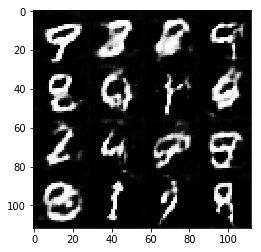

Epoch 0/2 Batch Step 710 .... Discriminator Loss: 0.8654.... Generator Loss: 0.9617...
Epoch 0/2 Batch Step 720 .... Discriminator Loss: 1.0475.... Generator Loss: 1.1053...
Epoch 0/2 Batch Step 730 .... Discriminator Loss: 1.4387.... Generator Loss: 2.1388...
Epoch 0/2 Batch Step 740 .... Discriminator Loss: 1.0960.... Generator Loss: 0.6077...
Epoch 0/2 Batch Step 750 .... Discriminator Loss: 1.0345.... Generator Loss: 2.5736...
Epoch 0/2 Batch Step 760 .... Discriminator Loss: 0.8056.... Generator Loss: 1.1548...
Epoch 0/2 Batch Step 770 .... Discriminator Loss: 0.8366.... Generator Loss: 0.9521...
Epoch 0/2 Batch Step 780 .... Discriminator Loss: 0.8345.... Generator Loss: 1.1493...
Epoch 0/2 Batch Step 790 .... Discriminator Loss: 1.1613.... Generator Loss: 1.0698...
Epoch 0/2 Batch Step 800 .... Discriminator Loss: 0.9454.... Generator Loss: 1.0927...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 1)


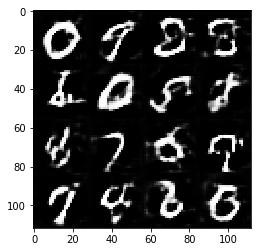

Epoch 0/2 Batch Step 810 .... Discriminator Loss: 0.5942.... Generator Loss: 1.3872...
Epoch 0/2 Batch Step 820 .... Discriminator Loss: 1.5746.... Generator Loss: 0.3347...
Epoch 0/2 Batch Step 830 .... Discriminator Loss: 0.9966.... Generator Loss: 0.8556...
Epoch 0/2 Batch Step 840 .... Discriminator Loss: 0.8313.... Generator Loss: 1.0211...
Epoch 0/2 Batch Step 850 .... Discriminator Loss: 1.2054.... Generator Loss: 0.5445...
Epoch 0/2 Batch Step 860 .... Discriminator Loss: 0.8945.... Generator Loss: 1.4314...
Epoch 0/2 Batch Step 870 .... Discriminator Loss: 1.0764.... Generator Loss: 0.6394...
Epoch 0/2 Batch Step 880 .... Discriminator Loss: 1.4102.... Generator Loss: 2.4244...
Epoch 0/2 Batch Step 890 .... Discriminator Loss: 1.1501.... Generator Loss: 2.4811...
Epoch 0/2 Batch Step 900 .... Discriminator Loss: 1.2880.... Generator Loss: 2.9048...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 1)


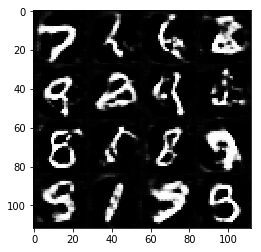

Epoch 0/2 Batch Step 910 .... Discriminator Loss: 0.8326.... Generator Loss: 1.3810...
Epoch 0/2 Batch Step 920 .... Discriminator Loss: 0.7649.... Generator Loss: 1.6348...
Epoch 0/2 Batch Step 930 .... Discriminator Loss: 0.8310.... Generator Loss: 1.4079...
Epoch 1/2 Batch Step 940 .... Discriminator Loss: 0.7339.... Generator Loss: 1.4460...
Epoch 1/2 Batch Step 950 .... Discriminator Loss: 2.0661.... Generator Loss: 0.2532...
Epoch 1/2 Batch Step 960 .... Discriminator Loss: 0.8812.... Generator Loss: 1.7320...
Epoch 1/2 Batch Step 970 .... Discriminator Loss: 0.7198.... Generator Loss: 2.6485...
Epoch 1/2 Batch Step 980 .... Discriminator Loss: 0.7093.... Generator Loss: 1.2865...
Epoch 1/2 Batch Step 990 .... Discriminator Loss: 1.0590.... Generator Loss: 1.3565...
Epoch 1/2 Batch Step 1000 .... Discriminator Loss: 1.5836.... Generator Loss: 0.3243...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 1)


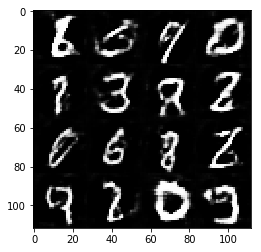

Epoch 1/2 Batch Step 1010 .... Discriminator Loss: 0.7196.... Generator Loss: 1.2318...
Epoch 1/2 Batch Step 1020 .... Discriminator Loss: 0.9728.... Generator Loss: 0.9036...
Epoch 1/2 Batch Step 1030 .... Discriminator Loss: 0.8350.... Generator Loss: 1.1704...
Epoch 1/2 Batch Step 1040 .... Discriminator Loss: 0.8195.... Generator Loss: 1.2239...
Epoch 1/2 Batch Step 1050 .... Discriminator Loss: 1.8286.... Generator Loss: 2.5935...
Epoch 1/2 Batch Step 1060 .... Discriminator Loss: 0.8362.... Generator Loss: 1.4303...
Epoch 1/2 Batch Step 1070 .... Discriminator Loss: 0.9750.... Generator Loss: 1.3780...
Epoch 1/2 Batch Step 1080 .... Discriminator Loss: 0.7942.... Generator Loss: 1.7530...
Epoch 1/2 Batch Step 1090 .... Discriminator Loss: 1.0798.... Generator Loss: 0.6510...
Epoch 1/2 Batch Step 1100 .... Discriminator Loss: 0.5600.... Generator Loss: 2.4823...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 1)


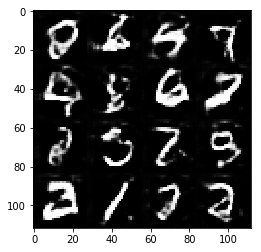

Epoch 1/2 Batch Step 1110 .... Discriminator Loss: 1.0140.... Generator Loss: 1.2942...
Epoch 1/2 Batch Step 1120 .... Discriminator Loss: 0.9824.... Generator Loss: 0.9475...
Epoch 1/2 Batch Step 1130 .... Discriminator Loss: 1.1596.... Generator Loss: 0.5793...
Epoch 1/2 Batch Step 1140 .... Discriminator Loss: 0.7760.... Generator Loss: 1.7062...
Epoch 1/2 Batch Step 1150 .... Discriminator Loss: 0.9593.... Generator Loss: 1.8587...
Epoch 1/2 Batch Step 1160 .... Discriminator Loss: 1.9901.... Generator Loss: 3.7153...
Epoch 1/2 Batch Step 1170 .... Discriminator Loss: 0.7675.... Generator Loss: 1.0574...
Epoch 1/2 Batch Step 1180 .... Discriminator Loss: 0.7530.... Generator Loss: 1.3967...
Epoch 1/2 Batch Step 1190 .... Discriminator Loss: 1.3926.... Generator Loss: 1.6483...
Epoch 1/2 Batch Step 1200 .... Discriminator Loss: 1.6948.... Generator Loss: 2.4337...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 1)


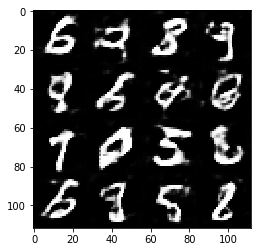

Epoch 1/2 Batch Step 1210 .... Discriminator Loss: 0.7628.... Generator Loss: 1.3492...
Epoch 1/2 Batch Step 1220 .... Discriminator Loss: 0.8235.... Generator Loss: 1.2202...
Epoch 1/2 Batch Step 1230 .... Discriminator Loss: 0.9096.... Generator Loss: 0.7398...
Epoch 1/2 Batch Step 1240 .... Discriminator Loss: 0.5444.... Generator Loss: 2.3705...
Epoch 1/2 Batch Step 1250 .... Discriminator Loss: 0.7150.... Generator Loss: 1.3554...
Epoch 1/2 Batch Step 1260 .... Discriminator Loss: 0.8228.... Generator Loss: 0.8915...
Epoch 1/2 Batch Step 1270 .... Discriminator Loss: 0.8170.... Generator Loss: 0.8070...
Epoch 1/2 Batch Step 1280 .... Discriminator Loss: 0.5041.... Generator Loss: 2.1310...
Epoch 1/2 Batch Step 1290 .... Discriminator Loss: 2.2894.... Generator Loss: 4.4601...
Epoch 1/2 Batch Step 1300 .... Discriminator Loss: 0.9923.... Generator Loss: 1.0658...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 1)


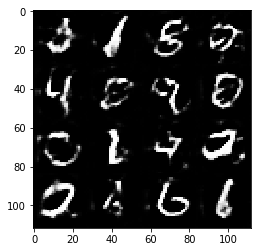

Epoch 1/2 Batch Step 1310 .... Discriminator Loss: 0.8826.... Generator Loss: 0.9455...
Epoch 1/2 Batch Step 1320 .... Discriminator Loss: 1.8293.... Generator Loss: 0.2544...
Epoch 1/2 Batch Step 1330 .... Discriminator Loss: 0.6517.... Generator Loss: 1.2389...
Epoch 1/2 Batch Step 1340 .... Discriminator Loss: 1.0355.... Generator Loss: 0.6658...
Epoch 1/2 Batch Step 1350 .... Discriminator Loss: 0.9467.... Generator Loss: 1.3337...
Epoch 1/2 Batch Step 1360 .... Discriminator Loss: 0.7746.... Generator Loss: 1.0475...
Epoch 1/2 Batch Step 1370 .... Discriminator Loss: 1.2091.... Generator Loss: 0.5088...
Epoch 1/2 Batch Step 1380 .... Discriminator Loss: 1.8345.... Generator Loss: 0.2858...
Epoch 1/2 Batch Step 1390 .... Discriminator Loss: 0.9597.... Generator Loss: 0.7341...
Epoch 1/2 Batch Step 1400 .... Discriminator Loss: 1.0919.... Generator Loss: 1.1472...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 1)


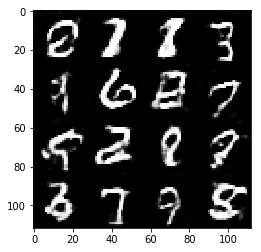

Epoch 1/2 Batch Step 1410 .... Discriminator Loss: 0.6639.... Generator Loss: 1.1441...
Epoch 1/2 Batch Step 1420 .... Discriminator Loss: 0.5775.... Generator Loss: 1.1544...
Epoch 1/2 Batch Step 1430 .... Discriminator Loss: 3.0619.... Generator Loss: 4.8667...
Epoch 1/2 Batch Step 1440 .... Discriminator Loss: 0.9619.... Generator Loss: 1.1146...
Epoch 1/2 Batch Step 1450 .... Discriminator Loss: 0.6409.... Generator Loss: 1.3378...
Epoch 1/2 Batch Step 1460 .... Discriminator Loss: 0.4639.... Generator Loss: 1.3906...
Epoch 1/2 Batch Step 1470 .... Discriminator Loss: 0.8986.... Generator Loss: 0.7876...
Epoch 1/2 Batch Step 1480 .... Discriminator Loss: 0.4511.... Generator Loss: 1.3871...
Epoch 1/2 Batch Step 1490 .... Discriminator Loss: 1.4780.... Generator Loss: 0.5382...
Epoch 1/2 Batch Step 1500 .... Discriminator Loss: 0.9433.... Generator Loss: 2.2492...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 1)


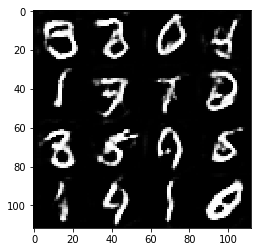

Epoch 1/2 Batch Step 1510 .... Discriminator Loss: 0.9595.... Generator Loss: 0.6884...
Epoch 1/2 Batch Step 1520 .... Discriminator Loss: 1.3887.... Generator Loss: 0.4701...
Epoch 1/2 Batch Step 1530 .... Discriminator Loss: 1.3784.... Generator Loss: 0.6908...
Epoch 1/2 Batch Step 1540 .... Discriminator Loss: 1.1143.... Generator Loss: 0.7058...
Epoch 1/2 Batch Step 1550 .... Discriminator Loss: 0.8399.... Generator Loss: 0.8225...
Epoch 1/2 Batch Step 1560 .... Discriminator Loss: 0.6508.... Generator Loss: 1.0284...
Epoch 1/2 Batch Step 1570 .... Discriminator Loss: 1.2875.... Generator Loss: 0.7127...
Epoch 1/2 Batch Step 1580 .... Discriminator Loss: 0.6723.... Generator Loss: 1.4500...
Epoch 1/2 Batch Step 1590 .... Discriminator Loss: 0.3875.... Generator Loss: 1.6957...
Epoch 1/2 Batch Step 1600 .... Discriminator Loss: 0.3250.... Generator Loss: 2.3115...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 1)


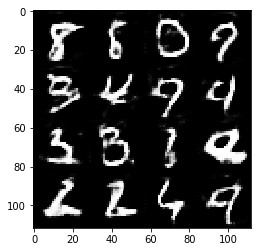

Epoch 1/2 Batch Step 1610 .... Discriminator Loss: 0.6588.... Generator Loss: 1.0779...
Epoch 1/2 Batch Step 1620 .... Discriminator Loss: 0.3284.... Generator Loss: 1.8746...
Epoch 1/2 Batch Step 1630 .... Discriminator Loss: 0.1368.... Generator Loss: 2.6873...
Epoch 1/2 Batch Step 1640 .... Discriminator Loss: 3.8056.... Generator Loss: 7.2086...
Epoch 1/2 Batch Step 1650 .... Discriminator Loss: 0.9054.... Generator Loss: 1.4654...
Epoch 1/2 Batch Step 1660 .... Discriminator Loss: 1.0708.... Generator Loss: 0.5883...
Epoch 1/2 Batch Step 1670 .... Discriminator Loss: 1.0204.... Generator Loss: 0.7823...
Epoch 1/2 Batch Step 1680 .... Discriminator Loss: 0.4726.... Generator Loss: 1.5161...
Epoch 1/2 Batch Step 1690 .... Discriminator Loss: 0.5836.... Generator Loss: 1.1664...
Epoch 1/2 Batch Step 1700 .... Discriminator Loss: 1.9994.... Generator Loss: 0.3340...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 1)


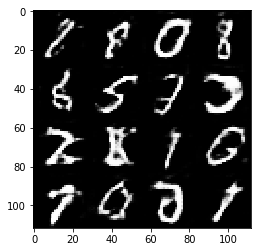

Epoch 1/2 Batch Step 1710 .... Discriminator Loss: 1.0513.... Generator Loss: 1.8541...
Epoch 1/2 Batch Step 1720 .... Discriminator Loss: 0.8603.... Generator Loss: 0.9285...
Epoch 1/2 Batch Step 1730 .... Discriminator Loss: 0.8158.... Generator Loss: 2.9654...
Epoch 1/2 Batch Step 1740 .... Discriminator Loss: 0.7903.... Generator Loss: 1.2692...
Epoch 1/2 Batch Step 1750 .... Discriminator Loss: 0.9042.... Generator Loss: 0.7955...
Epoch 1/2 Batch Step 1760 .... Discriminator Loss: 0.3846.... Generator Loss: 1.7060...
Epoch 1/2 Batch Step 1770 .... Discriminator Loss: 0.4866.... Generator Loss: 1.3202...
Epoch 1/2 Batch Step 1780 .... Discriminator Loss: 0.6127.... Generator Loss: 1.1508...
Epoch 1/2 Batch Step 1790 .... Discriminator Loss: 2.0376.... Generator Loss: 0.2163...
Epoch 1/2 Batch Step 1800 .... Discriminator Loss: 1.4574.... Generator Loss: 0.4563...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 1)


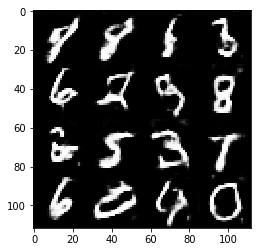

Epoch 1/2 Batch Step 1810 .... Discriminator Loss: 1.4273.... Generator Loss: 0.3813...
Epoch 1/2 Batch Step 1820 .... Discriminator Loss: 1.0213.... Generator Loss: 0.7309...
Epoch 1/2 Batch Step 1830 .... Discriminator Loss: 1.1422.... Generator Loss: 0.5352...
Epoch 1/2 Batch Step 1840 .... Discriminator Loss: 0.6406.... Generator Loss: 1.0575...
Epoch 1/2 Batch Step 1850 .... Discriminator Loss: 0.5292.... Generator Loss: 1.4774...
Epoch 1/2 Batch Step 1860 .... Discriminator Loss: 0.3448.... Generator Loss: 1.6521...
Epoch 1/2 Batch Step 1870 .... Discriminator Loss: 0.5085.... Generator Loss: 1.2774...
 Finished Training, Yay ! 


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)
Starting Training .. 
Epoch 0/1 Batch Step 10 .... Discriminator Loss: 2.5352.... Generator Loss: 0.1664...
Epoch 0/1 Batch Step 20 .... Discriminator Loss: 0.0583.... Generator Loss: 15.8909...
Epoch 0/1 Batch Step 30 .... Discriminator Loss: 0.0620.... Generator Loss: 2.9747...
Epoch 0/1 Batch Step 40 .... Discriminator Loss: 0.0234.... Generator Loss: 4.2195...
Epoch 0/1 Batch Step 50 .... Discriminator Loss: 0.1112.... Generator Loss: 2.7904...
Epoch 0/1 Batch Step 60 .... Discriminator Loss: 1.6165.... Generator Loss: 20.8718...
Epoch 0/1 Batch Step 70 .... Discriminator Loss: 0.4733.... Generator Loss: 18.5245...
Epoch 0/1 Batch Step 80 .... Discriminator Loss: 0.0433.... Generator Loss: 3.7322...
Epoch 0/1 Batch Step 90 .... Discriminator Loss: 0.1803.... Generator Loss: 4.0319...
Epoch 0/1 Batch Step 100 .... Discriminator Loss: 0.2423.... Generator Loss: 2.6790...


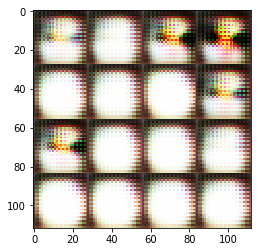

Epoch 0/1 Batch Step 110 .... Discriminator Loss: 0.1408.... Generator Loss: 6.1031...
Epoch 0/1 Batch Step 120 .... Discriminator Loss: 2.9813.... Generator Loss: 0.2436...
Epoch 0/1 Batch Step 130 .... Discriminator Loss: 1.0375.... Generator Loss: 7.7907...
Epoch 0/1 Batch Step 140 .... Discriminator Loss: 0.3157.... Generator Loss: 1.4278...
Epoch 0/1 Batch Step 150 .... Discriminator Loss: 0.0045.... Generator Loss: 6.4719...
Epoch 0/1 Batch Step 160 .... Discriminator Loss: 0.0263.... Generator Loss: 4.6866...
Epoch 0/1 Batch Step 170 .... Discriminator Loss: 2.8079.... Generator Loss: 7.8130...
Epoch 0/1 Batch Step 180 .... Discriminator Loss: 0.2743.... Generator Loss: 2.5967...
Epoch 0/1 Batch Step 190 .... Discriminator Loss: 3.4712.... Generator Loss: 12.5850...
Epoch 0/1 Batch Step 200 .... Discriminator Loss: 0.1503.... Generator Loss: 5.7434...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


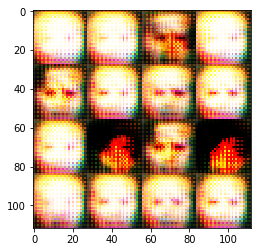

Epoch 0/1 Batch Step 210 .... Discriminator Loss: 1.2499.... Generator Loss: 0.6147...
Epoch 0/1 Batch Step 220 .... Discriminator Loss: 0.2617.... Generator Loss: 3.8936...
Epoch 0/1 Batch Step 230 .... Discriminator Loss: 1.1776.... Generator Loss: 0.4942...
Epoch 0/1 Batch Step 240 .... Discriminator Loss: 0.2638.... Generator Loss: 7.7276...
Epoch 0/1 Batch Step 250 .... Discriminator Loss: 1.6712.... Generator Loss: 0.2839...
Epoch 0/1 Batch Step 260 .... Discriminator Loss: 0.2196.... Generator Loss: 1.9411...
Epoch 0/1 Batch Step 270 .... Discriminator Loss: 0.3933.... Generator Loss: 3.8814...
Epoch 0/1 Batch Step 280 .... Discriminator Loss: 0.6204.... Generator Loss: 1.0738...
Epoch 0/1 Batch Step 290 .... Discriminator Loss: 0.5393.... Generator Loss: 1.2063...
Epoch 0/1 Batch Step 300 .... Discriminator Loss: 0.4507.... Generator Loss: 6.3400...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


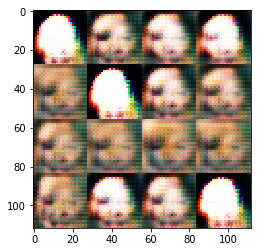

Epoch 0/1 Batch Step 310 .... Discriminator Loss: 0.0626.... Generator Loss: 5.4303...
Epoch 0/1 Batch Step 320 .... Discriminator Loss: 0.0632.... Generator Loss: 3.9788...
Epoch 0/1 Batch Step 330 .... Discriminator Loss: 1.8538.... Generator Loss: 0.2803...
Epoch 0/1 Batch Step 340 .... Discriminator Loss: 0.3138.... Generator Loss: 2.0268...
Epoch 0/1 Batch Step 350 .... Discriminator Loss: 0.2144.... Generator Loss: 2.6675...
Epoch 0/1 Batch Step 360 .... Discriminator Loss: 0.1060.... Generator Loss: 2.8248...
Epoch 0/1 Batch Step 370 .... Discriminator Loss: 0.1488.... Generator Loss: 2.7514...
Epoch 0/1 Batch Step 380 .... Discriminator Loss: 0.3289.... Generator Loss: 2.5107...
Epoch 0/1 Batch Step 390 .... Discriminator Loss: 0.2626.... Generator Loss: 2.1124...
Epoch 0/1 Batch Step 400 .... Discriminator Loss: 0.6094.... Generator Loss: 3.4455...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


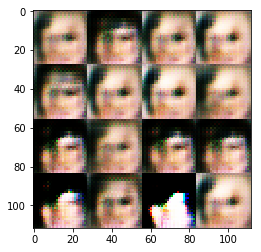

Epoch 0/1 Batch Step 410 .... Discriminator Loss: 2.8346.... Generator Loss: 0.0949...
Epoch 0/1 Batch Step 420 .... Discriminator Loss: 0.4181.... Generator Loss: 1.8915...
Epoch 0/1 Batch Step 430 .... Discriminator Loss: 0.3022.... Generator Loss: 3.9941...
Epoch 0/1 Batch Step 440 .... Discriminator Loss: 1.7602.... Generator Loss: 0.6275...
Epoch 0/1 Batch Step 450 .... Discriminator Loss: 0.2129.... Generator Loss: 2.6122...
Epoch 0/1 Batch Step 460 .... Discriminator Loss: 0.5896.... Generator Loss: 1.4999...
Epoch 0/1 Batch Step 470 .... Discriminator Loss: 0.4878.... Generator Loss: 1.8242...
Epoch 0/1 Batch Step 480 .... Discriminator Loss: 0.1412.... Generator Loss: 3.2517...
Epoch 0/1 Batch Step 490 .... Discriminator Loss: 0.0588.... Generator Loss: 4.5319...
Epoch 0/1 Batch Step 500 .... Discriminator Loss: 1.0462.... Generator Loss: 3.4814...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


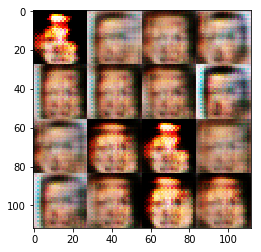

Epoch 0/1 Batch Step 510 .... Discriminator Loss: 0.5768.... Generator Loss: 1.6278...
Epoch 0/1 Batch Step 520 .... Discriminator Loss: 0.4732.... Generator Loss: 2.5050...
Epoch 0/1 Batch Step 530 .... Discriminator Loss: 0.7493.... Generator Loss: 4.1225...
Epoch 0/1 Batch Step 540 .... Discriminator Loss: 0.5242.... Generator Loss: 2.3636...
Epoch 0/1 Batch Step 550 .... Discriminator Loss: 0.2963.... Generator Loss: 1.7078...
Epoch 0/1 Batch Step 560 .... Discriminator Loss: 0.1700.... Generator Loss: 2.3659...
Epoch 0/1 Batch Step 570 .... Discriminator Loss: 0.5400.... Generator Loss: 1.5276...
Epoch 0/1 Batch Step 580 .... Discriminator Loss: 1.0005.... Generator Loss: 1.0687...
Epoch 0/1 Batch Step 590 .... Discriminator Loss: 1.4145.... Generator Loss: 0.4494...
Epoch 0/1 Batch Step 600 .... Discriminator Loss: 0.5354.... Generator Loss: 3.0662...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


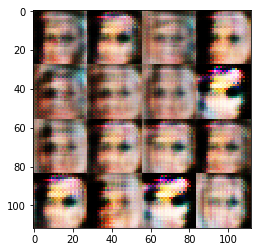

Epoch 0/1 Batch Step 610 .... Discriminator Loss: 1.3299.... Generator Loss: 0.3377...
Epoch 0/1 Batch Step 620 .... Discriminator Loss: 0.0713.... Generator Loss: 4.4004...
Epoch 0/1 Batch Step 630 .... Discriminator Loss: 0.8848.... Generator Loss: 5.1565...
Epoch 0/1 Batch Step 640 .... Discriminator Loss: 0.5273.... Generator Loss: 2.5238...
Epoch 0/1 Batch Step 650 .... Discriminator Loss: 0.8795.... Generator Loss: 1.6707...
Epoch 0/1 Batch Step 660 .... Discriminator Loss: 0.1787.... Generator Loss: 2.3116...
Epoch 0/1 Batch Step 670 .... Discriminator Loss: 0.1718.... Generator Loss: 2.3920...
Epoch 0/1 Batch Step 680 .... Discriminator Loss: 1.7940.... Generator Loss: 4.1423...
Epoch 0/1 Batch Step 690 .... Discriminator Loss: 0.9759.... Generator Loss: 4.5015...
Epoch 0/1 Batch Step 700 .... Discriminator Loss: 0.5877.... Generator Loss: 0.9552...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


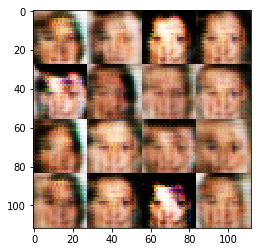

Epoch 0/1 Batch Step 710 .... Discriminator Loss: 2.4114.... Generator Loss: 3.3656...
Epoch 0/1 Batch Step 720 .... Discriminator Loss: 1.0602.... Generator Loss: 4.6865...
Epoch 0/1 Batch Step 730 .... Discriminator Loss: 1.0062.... Generator Loss: 0.6655...
Epoch 0/1 Batch Step 740 .... Discriminator Loss: 0.3082.... Generator Loss: 1.5619...
Epoch 0/1 Batch Step 750 .... Discriminator Loss: 2.8158.... Generator Loss: 4.9710...
Epoch 0/1 Batch Step 760 .... Discriminator Loss: 0.2892.... Generator Loss: 3.3177...
Epoch 0/1 Batch Step 770 .... Discriminator Loss: 0.5371.... Generator Loss: 1.1488...
Epoch 0/1 Batch Step 780 .... Discriminator Loss: 0.2832.... Generator Loss: 3.0263...
Epoch 0/1 Batch Step 790 .... Discriminator Loss: 0.5189.... Generator Loss: 1.2047...
Epoch 0/1 Batch Step 800 .... Discriminator Loss: 0.4802.... Generator Loss: 4.0894...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


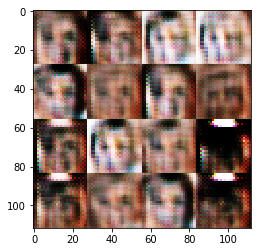

Epoch 0/1 Batch Step 810 .... Discriminator Loss: 0.9491.... Generator Loss: 1.4003...
Epoch 0/1 Batch Step 820 .... Discriminator Loss: 0.7997.... Generator Loss: 1.3895...
Epoch 0/1 Batch Step 830 .... Discriminator Loss: 0.9976.... Generator Loss: 1.2943...
Epoch 0/1 Batch Step 840 .... Discriminator Loss: 0.4073.... Generator Loss: 1.4799...
Epoch 0/1 Batch Step 850 .... Discriminator Loss: 0.5124.... Generator Loss: 1.4293...
Epoch 0/1 Batch Step 860 .... Discriminator Loss: 0.0901.... Generator Loss: 3.4547...
Epoch 0/1 Batch Step 870 .... Discriminator Loss: 1.7447.... Generator Loss: 4.7457...
Epoch 0/1 Batch Step 880 .... Discriminator Loss: 1.4148.... Generator Loss: 0.7816...
Epoch 0/1 Batch Step 890 .... Discriminator Loss: 1.3318.... Generator Loss: 0.8224...
Epoch 0/1 Batch Step 900 .... Discriminator Loss: 1.0055.... Generator Loss: 0.8678...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


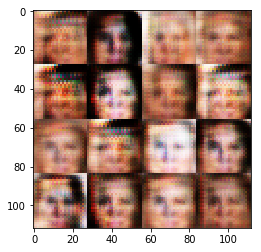

Epoch 0/1 Batch Step 910 .... Discriminator Loss: 0.6128.... Generator Loss: 1.1810...
Epoch 0/1 Batch Step 920 .... Discriminator Loss: 1.0363.... Generator Loss: 0.8410...
Epoch 0/1 Batch Step 930 .... Discriminator Loss: 1.0664.... Generator Loss: 0.6837...
Epoch 0/1 Batch Step 940 .... Discriminator Loss: 0.8795.... Generator Loss: 0.7606...
Epoch 0/1 Batch Step 950 .... Discriminator Loss: 0.1759.... Generator Loss: 2.2961...
Epoch 0/1 Batch Step 960 .... Discriminator Loss: 1.3619.... Generator Loss: 1.6359...
Epoch 0/1 Batch Step 970 .... Discriminator Loss: 0.5146.... Generator Loss: 2.9317...
Epoch 0/1 Batch Step 980 .... Discriminator Loss: 1.4889.... Generator Loss: 1.2840...
Epoch 0/1 Batch Step 990 .... Discriminator Loss: 0.1100.... Generator Loss: 4.7768...
Epoch 0/1 Batch Step 1000 .... Discriminator Loss: 0.3363.... Generator Loss: 1.6480...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


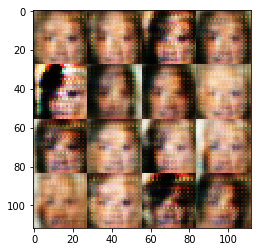

Epoch 0/1 Batch Step 1010 .... Discriminator Loss: 0.4571.... Generator Loss: 1.7304...
Epoch 0/1 Batch Step 1020 .... Discriminator Loss: 1.0437.... Generator Loss: 0.6290...
Epoch 0/1 Batch Step 1030 .... Discriminator Loss: 0.1712.... Generator Loss: 2.6481...
Epoch 0/1 Batch Step 1040 .... Discriminator Loss: 0.1288.... Generator Loss: 3.2292...
Epoch 0/1 Batch Step 1050 .... Discriminator Loss: 2.3369.... Generator Loss: 0.1811...
Epoch 0/1 Batch Step 1060 .... Discriminator Loss: 0.6959.... Generator Loss: 0.9898...
Epoch 0/1 Batch Step 1070 .... Discriminator Loss: 0.6562.... Generator Loss: 2.0172...
Epoch 0/1 Batch Step 1080 .... Discriminator Loss: 0.5445.... Generator Loss: 1.0384...
Epoch 0/1 Batch Step 1090 .... Discriminator Loss: 0.4344.... Generator Loss: 1.3326...
Epoch 0/1 Batch Step 1100 .... Discriminator Loss: 0.8400.... Generator Loss: 0.7193...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


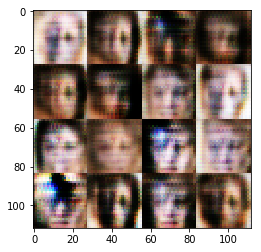

Epoch 0/1 Batch Step 1110 .... Discriminator Loss: 0.2488.... Generator Loss: 2.1399...
Epoch 0/1 Batch Step 1120 .... Discriminator Loss: 0.1437.... Generator Loss: 2.3581...
Epoch 0/1 Batch Step 1130 .... Discriminator Loss: 0.7007.... Generator Loss: 3.7629...
Epoch 0/1 Batch Step 1140 .... Discriminator Loss: 0.3244.... Generator Loss: 1.6592...
Epoch 0/1 Batch Step 1150 .... Discriminator Loss: 0.7884.... Generator Loss: 0.7438...
Epoch 0/1 Batch Step 1160 .... Discriminator Loss: 0.1229.... Generator Loss: 3.1115...
Epoch 0/1 Batch Step 1170 .... Discriminator Loss: 0.4517.... Generator Loss: 1.1784...
Epoch 0/1 Batch Step 1180 .... Discriminator Loss: 0.0471.... Generator Loss: 4.0992...
Epoch 0/1 Batch Step 1190 .... Discriminator Loss: 3.6079.... Generator Loss: 0.0682...
Epoch 0/1 Batch Step 1200 .... Discriminator Loss: 1.0928.... Generator Loss: 1.0151...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


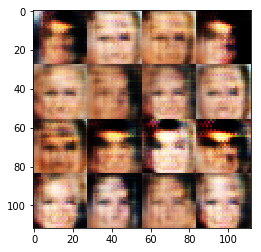

Epoch 0/1 Batch Step 1210 .... Discriminator Loss: 0.8905.... Generator Loss: 1.0522...
Epoch 0/1 Batch Step 1220 .... Discriminator Loss: 1.3508.... Generator Loss: 0.5653...
Epoch 0/1 Batch Step 1230 .... Discriminator Loss: 0.8285.... Generator Loss: 0.9383...
Epoch 0/1 Batch Step 1240 .... Discriminator Loss: 0.9365.... Generator Loss: 1.0048...
Epoch 0/1 Batch Step 1250 .... Discriminator Loss: 1.2132.... Generator Loss: 0.6617...
Epoch 0/1 Batch Step 1260 .... Discriminator Loss: 0.9798.... Generator Loss: 1.4265...
Epoch 0/1 Batch Step 1270 .... Discriminator Loss: 2.0202.... Generator Loss: 0.1846...
Epoch 0/1 Batch Step 1280 .... Discriminator Loss: 0.4992.... Generator Loss: 1.2001...
Epoch 0/1 Batch Step 1290 .... Discriminator Loss: 0.2028.... Generator Loss: 2.6035...
Epoch 0/1 Batch Step 1300 .... Discriminator Loss: 0.1478.... Generator Loss: 2.6539...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


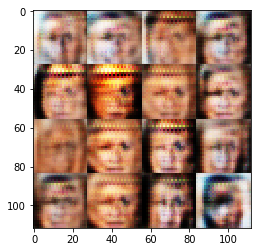

Epoch 0/1 Batch Step 1310 .... Discriminator Loss: 0.0385.... Generator Loss: 6.6429...
Epoch 0/1 Batch Step 1320 .... Discriminator Loss: 0.0311.... Generator Loss: 4.8657...
Epoch 0/1 Batch Step 1330 .... Discriminator Loss: 1.6887.... Generator Loss: 1.4578...
Epoch 0/1 Batch Step 1340 .... Discriminator Loss: 0.9799.... Generator Loss: 1.0707...
Epoch 0/1 Batch Step 1350 .... Discriminator Loss: 1.1073.... Generator Loss: 2.0386...
Epoch 0/1 Batch Step 1360 .... Discriminator Loss: 0.9181.... Generator Loss: 1.0088...
Epoch 0/1 Batch Step 1370 .... Discriminator Loss: 1.0660.... Generator Loss: 1.4336...
Epoch 0/1 Batch Step 1380 .... Discriminator Loss: 0.9719.... Generator Loss: 3.3613...
Epoch 0/1 Batch Step 1390 .... Discriminator Loss: 0.5678.... Generator Loss: 1.0504...
Epoch 0/1 Batch Step 1400 .... Discriminator Loss: 0.2295.... Generator Loss: 2.3086...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


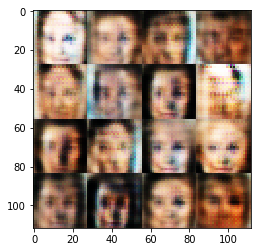

Epoch 0/1 Batch Step 1410 .... Discriminator Loss: 1.2186.... Generator Loss: 3.7869...
Epoch 0/1 Batch Step 1420 .... Discriminator Loss: 0.1661.... Generator Loss: 2.8656...
Epoch 0/1 Batch Step 1430 .... Discriminator Loss: 0.0605.... Generator Loss: 3.5963...
Epoch 0/1 Batch Step 1440 .... Discriminator Loss: 3.7112.... Generator Loss: 5.3635...
Epoch 0/1 Batch Step 1450 .... Discriminator Loss: 1.2851.... Generator Loss: 0.4908...
Epoch 0/1 Batch Step 1460 .... Discriminator Loss: 0.0592.... Generator Loss: 4.0736...
Epoch 0/1 Batch Step 1470 .... Discriminator Loss: 0.3743.... Generator Loss: 3.8100...
Epoch 0/1 Batch Step 1480 .... Discriminator Loss: 0.1729.... Generator Loss: 2.3358...
Epoch 0/1 Batch Step 1490 .... Discriminator Loss: 1.2693.... Generator Loss: 0.7937...
Epoch 0/1 Batch Step 1500 .... Discriminator Loss: 1.3522.... Generator Loss: 0.8638...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


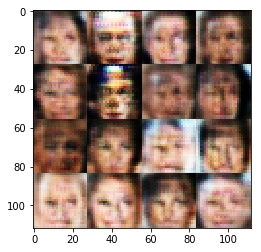

Epoch 0/1 Batch Step 1510 .... Discriminator Loss: 1.3455.... Generator Loss: 1.5125...
Epoch 0/1 Batch Step 1520 .... Discriminator Loss: 1.0656.... Generator Loss: 0.8013...
Epoch 0/1 Batch Step 1530 .... Discriminator Loss: 1.1709.... Generator Loss: 1.3809...
Epoch 0/1 Batch Step 1540 .... Discriminator Loss: 1.1110.... Generator Loss: 0.6236...
Epoch 0/1 Batch Step 1550 .... Discriminator Loss: 0.7790.... Generator Loss: 1.0132...
Epoch 0/1 Batch Step 1560 .... Discriminator Loss: 0.6711.... Generator Loss: 1.4829...
Epoch 0/1 Batch Step 1570 .... Discriminator Loss: 0.4844.... Generator Loss: 1.2294...
Epoch 0/1 Batch Step 1580 .... Discriminator Loss: 0.2002.... Generator Loss: 1.9233...
Epoch 0/1 Batch Step 1590 .... Discriminator Loss: 0.8277.... Generator Loss: 1.5056...
Epoch 0/1 Batch Step 1600 .... Discriminator Loss: 1.0540.... Generator Loss: 1.3259...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


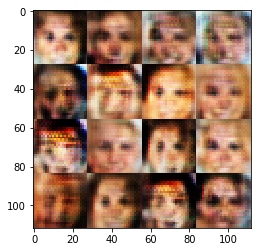

Epoch 0/1 Batch Step 1610 .... Discriminator Loss: 0.9893.... Generator Loss: 1.1470...
Epoch 0/1 Batch Step 1620 .... Discriminator Loss: 0.9754.... Generator Loss: 1.4554...
Epoch 0/1 Batch Step 1630 .... Discriminator Loss: 0.9825.... Generator Loss: 1.8627...
Epoch 0/1 Batch Step 1640 .... Discriminator Loss: 0.7217.... Generator Loss: 1.7995...
Epoch 0/1 Batch Step 1650 .... Discriminator Loss: 3.0067.... Generator Loss: 0.0861...
Epoch 0/1 Batch Step 1660 .... Discriminator Loss: 0.1084.... Generator Loss: 3.0981...
Epoch 0/1 Batch Step 1670 .... Discriminator Loss: 1.5309.... Generator Loss: 0.3811...
Epoch 0/1 Batch Step 1680 .... Discriminator Loss: 0.9351.... Generator Loss: 1.1637...
Epoch 0/1 Batch Step 1690 .... Discriminator Loss: 1.5149.... Generator Loss: 2.3495...
Epoch 0/1 Batch Step 1700 .... Discriminator Loss: 0.8489.... Generator Loss: 1.2203...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


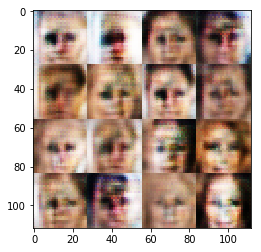

Epoch 0/1 Batch Step 1710 .... Discriminator Loss: 1.9324.... Generator Loss: 0.2299...
Epoch 0/1 Batch Step 1720 .... Discriminator Loss: 0.6291.... Generator Loss: 0.9403...
Epoch 0/1 Batch Step 1730 .... Discriminator Loss: 0.0742.... Generator Loss: 3.3933...
Epoch 0/1 Batch Step 1740 .... Discriminator Loss: 0.4928.... Generator Loss: 3.1731...
Epoch 0/1 Batch Step 1750 .... Discriminator Loss: 3.4645.... Generator Loss: 0.0460...
Epoch 0/1 Batch Step 1760 .... Discriminator Loss: 1.0897.... Generator Loss: 0.6025...
Epoch 0/1 Batch Step 1770 .... Discriminator Loss: 0.5867.... Generator Loss: 3.0890...
Epoch 0/1 Batch Step 1780 .... Discriminator Loss: 0.1460.... Generator Loss: 3.2236...
Epoch 0/1 Batch Step 1790 .... Discriminator Loss: 0.1742.... Generator Loss: 3.1062...
Epoch 0/1 Batch Step 1800 .... Discriminator Loss: 0.9863.... Generator Loss: 5.9074...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


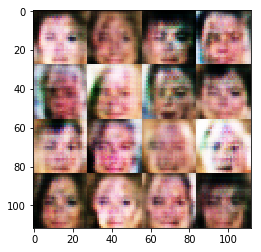

Epoch 0/1 Batch Step 1810 .... Discriminator Loss: 1.0678.... Generator Loss: 0.8739...
Epoch 0/1 Batch Step 1820 .... Discriminator Loss: 0.4618.... Generator Loss: 1.1906...
Epoch 0/1 Batch Step 1830 .... Discriminator Loss: 0.4971.... Generator Loss: 1.2660...
Epoch 0/1 Batch Step 1840 .... Discriminator Loss: 0.9062.... Generator Loss: 1.4552...
Epoch 0/1 Batch Step 1850 .... Discriminator Loss: 0.9665.... Generator Loss: 1.8720...
Epoch 0/1 Batch Step 1860 .... Discriminator Loss: 1.0355.... Generator Loss: 1.6898...
Epoch 0/1 Batch Step 1870 .... Discriminator Loss: 0.8623.... Generator Loss: 1.0589...
Epoch 0/1 Batch Step 1880 .... Discriminator Loss: 0.2093.... Generator Loss: 2.1005...
Epoch 0/1 Batch Step 1890 .... Discriminator Loss: 0.2728.... Generator Loss: 2.4956...
Epoch 0/1 Batch Step 1900 .... Discriminator Loss: 0.5630.... Generator Loss: 3.7232...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


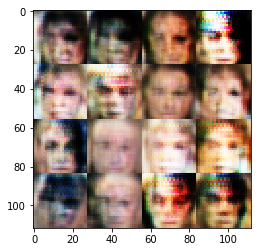

Epoch 0/1 Batch Step 1910 .... Discriminator Loss: 0.1869.... Generator Loss: 2.2413...
Epoch 0/1 Batch Step 1920 .... Discriminator Loss: 1.8373.... Generator Loss: 0.3081...
Epoch 0/1 Batch Step 1930 .... Discriminator Loss: 0.3649.... Generator Loss: 2.0923...
Epoch 0/1 Batch Step 1940 .... Discriminator Loss: 0.1911.... Generator Loss: 2.2155...
Epoch 0/1 Batch Step 1950 .... Discriminator Loss: 1.1402.... Generator Loss: 3.5448...
Epoch 0/1 Batch Step 1960 .... Discriminator Loss: 0.0774.... Generator Loss: 3.2875...
Epoch 0/1 Batch Step 1970 .... Discriminator Loss: 1.5753.... Generator Loss: 0.3135...
Epoch 0/1 Batch Step 1980 .... Discriminator Loss: 1.5219.... Generator Loss: 3.3880...
Epoch 0/1 Batch Step 1990 .... Discriminator Loss: 0.2459.... Generator Loss: 3.6782...
Epoch 0/1 Batch Step 2000 .... Discriminator Loss: 0.1076.... Generator Loss: 4.2514...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


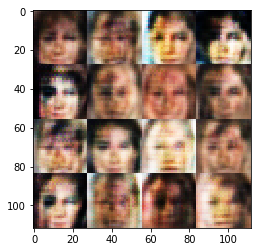

Epoch 0/1 Batch Step 2010 .... Discriminator Loss: 1.2356.... Generator Loss: 0.6909...
Epoch 0/1 Batch Step 2020 .... Discriminator Loss: 0.9180.... Generator Loss: 1.0642...
Epoch 0/1 Batch Step 2030 .... Discriminator Loss: 0.9017.... Generator Loss: 1.3623...
Epoch 0/1 Batch Step 2040 .... Discriminator Loss: 0.7018.... Generator Loss: 1.4354...
Epoch 0/1 Batch Step 2050 .... Discriminator Loss: 0.9497.... Generator Loss: 1.1387...
Epoch 0/1 Batch Step 2060 .... Discriminator Loss: 0.8931.... Generator Loss: 1.3802...
Epoch 0/1 Batch Step 2070 .... Discriminator Loss: 0.9216.... Generator Loss: 0.9735...
Epoch 0/1 Batch Step 2080 .... Discriminator Loss: 1.8285.... Generator Loss: 4.2589...
Epoch 0/1 Batch Step 2090 .... Discriminator Loss: 1.0968.... Generator Loss: 0.7000...
Epoch 0/1 Batch Step 2100 .... Discriminator Loss: 1.2760.... Generator Loss: 0.7063...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


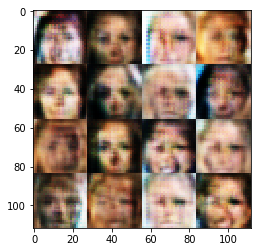

Epoch 0/1 Batch Step 2110 .... Discriminator Loss: 0.1059.... Generator Loss: 3.5941...
Epoch 0/1 Batch Step 2120 .... Discriminator Loss: 0.1685.... Generator Loss: 2.2737...
Epoch 0/1 Batch Step 2130 .... Discriminator Loss: 1.9375.... Generator Loss: 0.9957...
Epoch 0/1 Batch Step 2140 .... Discriminator Loss: 0.1249.... Generator Loss: 3.9152...
Epoch 0/1 Batch Step 2150 .... Discriminator Loss: 0.2677.... Generator Loss: 1.8345...
Epoch 0/1 Batch Step 2160 .... Discriminator Loss: 2.4500.... Generator Loss: 3.3465...
Epoch 0/1 Batch Step 2170 .... Discriminator Loss: 0.8825.... Generator Loss: 1.0607...
Epoch 0/1 Batch Step 2180 .... Discriminator Loss: 1.0699.... Generator Loss: 0.7740...
Epoch 0/1 Batch Step 2190 .... Discriminator Loss: 0.5866.... Generator Loss: 1.5152...
Epoch 0/1 Batch Step 2200 .... Discriminator Loss: 0.7778.... Generator Loss: 1.4691...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


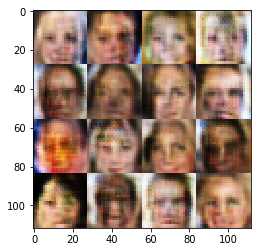

Epoch 0/1 Batch Step 2210 .... Discriminator Loss: 1.0763.... Generator Loss: 3.0254...
Epoch 0/1 Batch Step 2220 .... Discriminator Loss: 0.5692.... Generator Loss: 2.3355...
Epoch 0/1 Batch Step 2230 .... Discriminator Loss: 0.6495.... Generator Loss: 1.6824...
Epoch 0/1 Batch Step 2240 .... Discriminator Loss: 0.4711.... Generator Loss: 1.2641...
Epoch 0/1 Batch Step 2250 .... Discriminator Loss: 0.7793.... Generator Loss: 1.2383...
Epoch 0/1 Batch Step 2260 .... Discriminator Loss: 0.6821.... Generator Loss: 1.4214...
Epoch 0/1 Batch Step 2270 .... Discriminator Loss: 1.0307.... Generator Loss: 1.8941...
Epoch 0/1 Batch Step 2280 .... Discriminator Loss: 1.7970.... Generator Loss: 0.3140...
Epoch 0/1 Batch Step 2290 .... Discriminator Loss: 0.6782.... Generator Loss: 1.0024...
Epoch 0/1 Batch Step 2300 .... Discriminator Loss: 0.7783.... Generator Loss: 3.2806...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


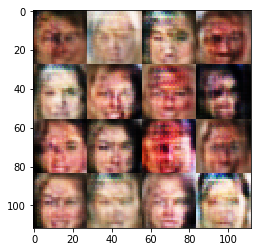

Epoch 0/1 Batch Step 2310 .... Discriminator Loss: 0.4969.... Generator Loss: 1.2961...
Epoch 0/1 Batch Step 2320 .... Discriminator Loss: 0.7149.... Generator Loss: 1.6024...
Epoch 0/1 Batch Step 2330 .... Discriminator Loss: 0.2192.... Generator Loss: 1.8791...
Epoch 0/1 Batch Step 2340 .... Discriminator Loss: 0.8721.... Generator Loss: 3.1639...
Epoch 0/1 Batch Step 2350 .... Discriminator Loss: 1.7659.... Generator Loss: 0.4131...
Epoch 0/1 Batch Step 2360 .... Discriminator Loss: 2.4798.... Generator Loss: 0.1396...
Epoch 0/1 Batch Step 2370 .... Discriminator Loss: 1.0033.... Generator Loss: 1.5271...
Epoch 0/1 Batch Step 2380 .... Discriminator Loss: 0.5878.... Generator Loss: 1.2519...
Epoch 0/1 Batch Step 2390 .... Discriminator Loss: 0.4840.... Generator Loss: 1.4370...
Epoch 0/1 Batch Step 2400 .... Discriminator Loss: 0.3762.... Generator Loss: 1.7101...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


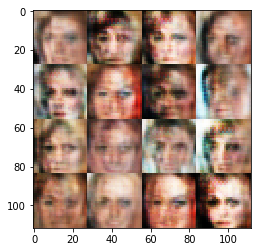

Epoch 0/1 Batch Step 2410 .... Discriminator Loss: 1.3350.... Generator Loss: 0.6432...
Epoch 0/1 Batch Step 2420 .... Discriminator Loss: 0.2673.... Generator Loss: 2.5131...
Epoch 0/1 Batch Step 2430 .... Discriminator Loss: 1.5588.... Generator Loss: 0.5259...
Epoch 0/1 Batch Step 2440 .... Discriminator Loss: 1.1825.... Generator Loss: 1.1217...
Epoch 0/1 Batch Step 2450 .... Discriminator Loss: 0.9534.... Generator Loss: 1.2324...
Epoch 0/1 Batch Step 2460 .... Discriminator Loss: 0.6826.... Generator Loss: 1.7216...
Epoch 0/1 Batch Step 2470 .... Discriminator Loss: 0.7999.... Generator Loss: 1.0613...
Epoch 0/1 Batch Step 2480 .... Discriminator Loss: 0.2611.... Generator Loss: 2.2970...
Epoch 0/1 Batch Step 2490 .... Discriminator Loss: 0.4350.... Generator Loss: 1.4536...
Epoch 0/1 Batch Step 2500 .... Discriminator Loss: 0.8248.... Generator Loss: 1.2962...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


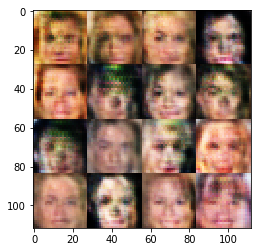

Epoch 0/1 Batch Step 2510 .... Discriminator Loss: 1.2100.... Generator Loss: 0.8302...
Epoch 0/1 Batch Step 2520 .... Discriminator Loss: 1.2034.... Generator Loss: 0.6283...
Epoch 0/1 Batch Step 2530 .... Discriminator Loss: 1.1591.... Generator Loss: 0.7369...
Epoch 0/1 Batch Step 2540 .... Discriminator Loss: 1.0941.... Generator Loss: 0.6732...
Epoch 0/1 Batch Step 2550 .... Discriminator Loss: 1.2659.... Generator Loss: 0.5229...
Epoch 0/1 Batch Step 2560 .... Discriminator Loss: 2.2830.... Generator Loss: 2.4391...
Epoch 0/1 Batch Step 2570 .... Discriminator Loss: 0.9337.... Generator Loss: 0.7898...
Epoch 0/1 Batch Step 2580 .... Discriminator Loss: 1.3688.... Generator Loss: 1.1982...
Epoch 0/1 Batch Step 2590 .... Discriminator Loss: 1.1321.... Generator Loss: 0.6524...
Epoch 0/1 Batch Step 2600 .... Discriminator Loss: 1.0620.... Generator Loss: 0.9729...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


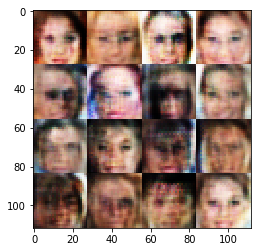

Epoch 0/1 Batch Step 2610 .... Discriminator Loss: 1.9476.... Generator Loss: 0.3146...
Epoch 0/1 Batch Step 2620 .... Discriminator Loss: 0.8682.... Generator Loss: 0.7553...
Epoch 0/1 Batch Step 2630 .... Discriminator Loss: 0.8964.... Generator Loss: 0.9869...
Epoch 0/1 Batch Step 2640 .... Discriminator Loss: 1.5379.... Generator Loss: 0.5503...
Epoch 0/1 Batch Step 2650 .... Discriminator Loss: 0.7915.... Generator Loss: 1.7258...
Epoch 0/1 Batch Step 2660 .... Discriminator Loss: 1.1563.... Generator Loss: 0.5506...
Epoch 0/1 Batch Step 2670 .... Discriminator Loss: 0.7121.... Generator Loss: 1.2303...
Epoch 0/1 Batch Step 2680 .... Discriminator Loss: 2.1789.... Generator Loss: 0.2064...
Epoch 0/1 Batch Step 2690 .... Discriminator Loss: 1.0448.... Generator Loss: 1.4561...
Epoch 0/1 Batch Step 2700 .... Discriminator Loss: 0.9714.... Generator Loss: 1.6815...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


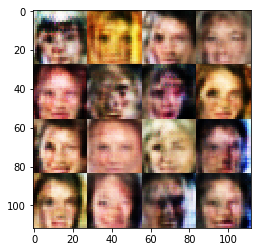

Epoch 0/1 Batch Step 2710 .... Discriminator Loss: 0.9376.... Generator Loss: 1.1056...
Epoch 0/1 Batch Step 2720 .... Discriminator Loss: 0.8187.... Generator Loss: 1.1258...
Epoch 0/1 Batch Step 2730 .... Discriminator Loss: 0.8512.... Generator Loss: 2.9131...
Epoch 0/1 Batch Step 2740 .... Discriminator Loss: 0.2715.... Generator Loss: 1.7047...
Epoch 0/1 Batch Step 2750 .... Discriminator Loss: 0.5713.... Generator Loss: 1.2148...
Epoch 0/1 Batch Step 2760 .... Discriminator Loss: 1.1630.... Generator Loss: 1.0560...
Epoch 0/1 Batch Step 2770 .... Discriminator Loss: 1.0677.... Generator Loss: 1.1407...
Epoch 0/1 Batch Step 2780 .... Discriminator Loss: 1.3778.... Generator Loss: 0.5827...
Epoch 0/1 Batch Step 2790 .... Discriminator Loss: 0.9492.... Generator Loss: 1.5706...
Epoch 0/1 Batch Step 2800 .... Discriminator Loss: 1.5193.... Generator Loss: 1.1302...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


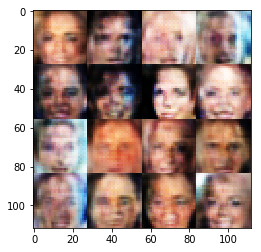

Epoch 0/1 Batch Step 2810 .... Discriminator Loss: 0.8009.... Generator Loss: 1.3000...
Epoch 0/1 Batch Step 2820 .... Discriminator Loss: 0.8971.... Generator Loss: 1.2683...
Epoch 0/1 Batch Step 2830 .... Discriminator Loss: 0.7046.... Generator Loss: 2.7967...
Epoch 0/1 Batch Step 2840 .... Discriminator Loss: 0.6981.... Generator Loss: 0.8677...
Epoch 0/1 Batch Step 2850 .... Discriminator Loss: 1.6835.... Generator Loss: 0.3121...
Epoch 0/1 Batch Step 2860 .... Discriminator Loss: 1.4808.... Generator Loss: 0.5952...
Epoch 0/1 Batch Step 2870 .... Discriminator Loss: 0.4401.... Generator Loss: 1.6380...
Epoch 0/1 Batch Step 2880 .... Discriminator Loss: 1.2345.... Generator Loss: 0.4924...
Epoch 0/1 Batch Step 2890 .... Discriminator Loss: 0.4322.... Generator Loss: 2.3426...
Epoch 0/1 Batch Step 2900 .... Discriminator Loss: 0.8529.... Generator Loss: 1.6119...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


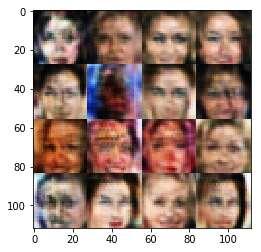

Epoch 0/1 Batch Step 2910 .... Discriminator Loss: 1.2332.... Generator Loss: 0.7587...
Epoch 0/1 Batch Step 2920 .... Discriminator Loss: 0.3455.... Generator Loss: 1.9702...
Epoch 0/1 Batch Step 2930 .... Discriminator Loss: 0.6311.... Generator Loss: 1.7939...
Epoch 0/1 Batch Step 2940 .... Discriminator Loss: 1.4179.... Generator Loss: 0.3939...
Epoch 0/1 Batch Step 2950 .... Discriminator Loss: 0.1866.... Generator Loss: 2.3156...
Epoch 0/1 Batch Step 2960 .... Discriminator Loss: 0.5541.... Generator Loss: 1.0591...
Epoch 0/1 Batch Step 2970 .... Discriminator Loss: 0.8086.... Generator Loss: 0.8135...
Epoch 0/1 Batch Step 2980 .... Discriminator Loss: 1.3897.... Generator Loss: 3.6174...
Epoch 0/1 Batch Step 2990 .... Discriminator Loss: 0.7680.... Generator Loss: 0.9017...
Epoch 0/1 Batch Step 3000 .... Discriminator Loss: 0.1865.... Generator Loss: 2.2035...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


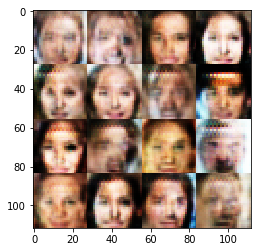

Epoch 0/1 Batch Step 3010 .... Discriminator Loss: 0.2166.... Generator Loss: 4.3974...
Epoch 0/1 Batch Step 3020 .... Discriminator Loss: 0.6002.... Generator Loss: 0.9497...
Epoch 0/1 Batch Step 3030 .... Discriminator Loss: 1.2188.... Generator Loss: 0.7764...
Epoch 0/1 Batch Step 3040 .... Discriminator Loss: 0.8861.... Generator Loss: 1.2669...
Epoch 0/1 Batch Step 3050 .... Discriminator Loss: 1.1357.... Generator Loss: 0.6345...
Epoch 0/1 Batch Step 3060 .... Discriminator Loss: 0.8233.... Generator Loss: 1.2085...
Epoch 0/1 Batch Step 3070 .... Discriminator Loss: 0.8222.... Generator Loss: 1.6515...
Epoch 0/1 Batch Step 3080 .... Discriminator Loss: 0.9487.... Generator Loss: 1.1413...
Epoch 0/1 Batch Step 3090 .... Discriminator Loss: 1.2163.... Generator Loss: 0.5888...
Epoch 0/1 Batch Step 3100 .... Discriminator Loss: 1.0387.... Generator Loss: 0.8888...
first-shape  (?, 4, 4, 512)
second-shape  (?, 9, 9, 256)
third-shape (?, 14, 14, 128)
logits-shape (?, 28, 28, 3)


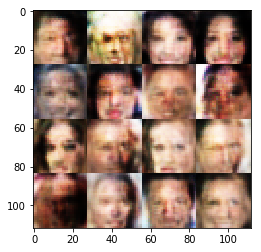

Epoch 0/1 Batch Step 3110 .... Discriminator Loss: 1.2492.... Generator Loss: 0.6097...
Epoch 0/1 Batch Step 3120 .... Discriminator Loss: 1.1583.... Generator Loss: 0.5415...
Epoch 0/1 Batch Step 3130 .... Discriminator Loss: 1.0407.... Generator Loss: 0.8509...
Epoch 0/1 Batch Step 3140 .... Discriminator Loss: 0.9476.... Generator Loss: 1.6170...
Epoch 0/1 Batch Step 3150 .... Discriminator Loss: 0.9342.... Generator Loss: 2.3827...
Epoch 0/1 Batch Step 3160 .... Discriminator Loss: 0.3112.... Generator Loss: 3.1716...
 Finished Training, Yay ! 


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.